In [2]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [4]:
dataset_dir = "/data_dir"
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 2.5.2. 欠損値の処理方法


base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets             

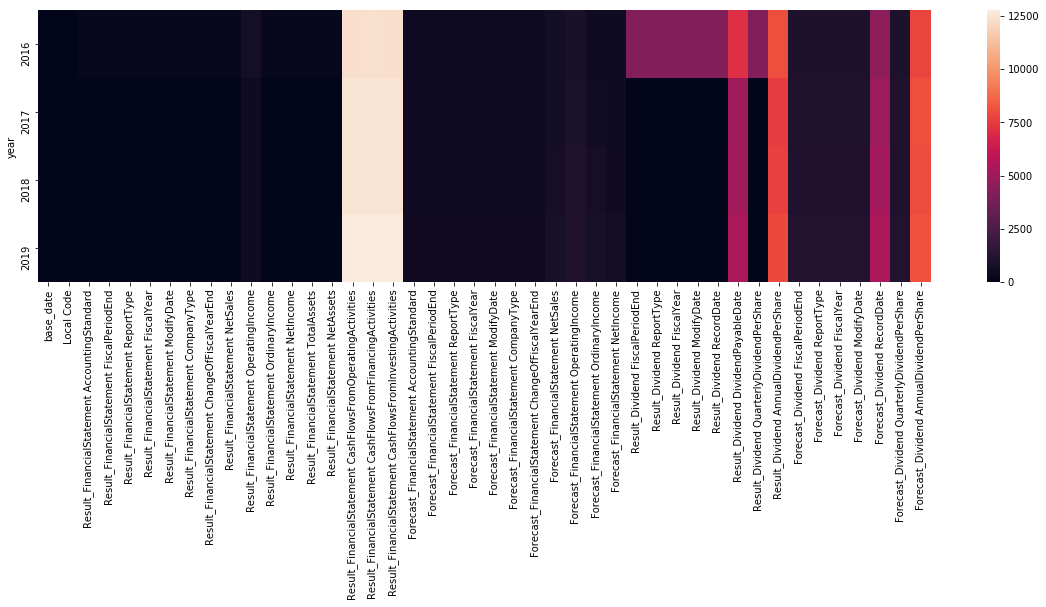

In [5]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
stock_fin["datetime"] = pd.to_datetime(stock_fin["base_date"])
stock_fin.set_index("datetime", inplace=True)
# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
# print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [10]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
stock_fin = stock_fin[stock_fin["Local Code"] == code]

# 日付列をpd.Timestamp型に変換してindexに設定
stock_fin["datetime"] = pd.to_datetime(stock_fin["base_date"])
stock_fin.set_index("datetime", inplace=True)

# float64型の列に絞り込み
fin_data = stock_fin.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

base_date                                                      0
Local Code                                                     0
Result_FinancialStatement AccountingStandard                   0
Result_FinancialStatement FiscalPeriodEnd                      0
Result_FinancialStatement ReportType                           0
Result_FinancialStatement FiscalYear                           0
Result_FinancialStatement ModifyDate                           0
Result_FinancialStatement CompanyType                          0
Result_FinancialStatement ChangeOfFiscalYearEnd                0
Result_FinancialStatement NetSales                             0
Result_FinancialStatement OperatingIncome                      3
Result_FinancialStatement OrdinaryIncome                       0
Result_FinancialStatement NetIncome                            0
Result_FinancialStatement TotalAssets                          0
Result_FinancialStatement NetAssets                            0
Result_FinancialStatement

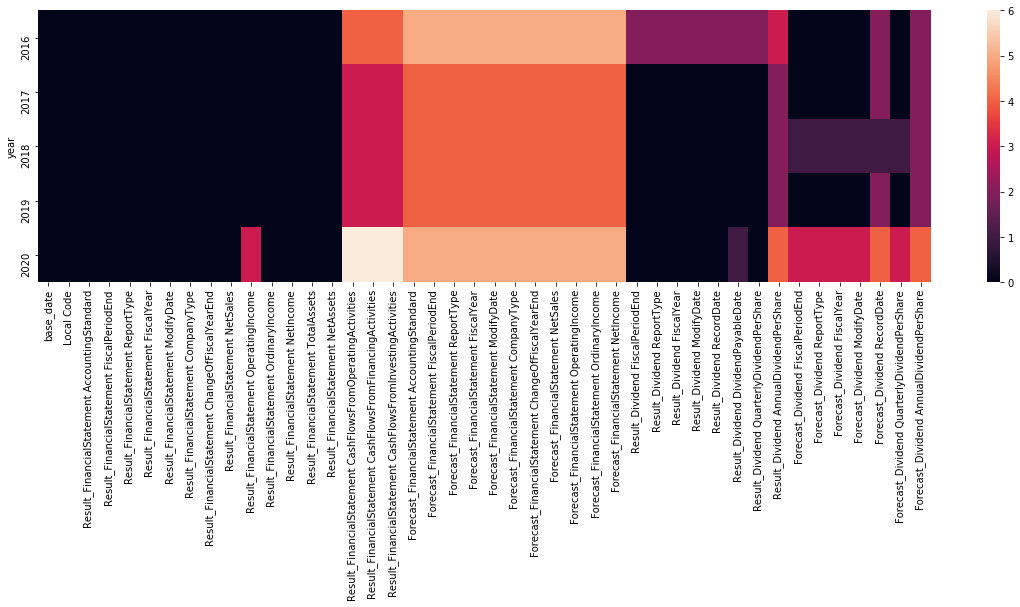

In [11]:

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)